# EVALUATION OF CLASSIFICATION RESULTS

In [108]:
import pandas as pd
import csv
import os
import numpy as np
import re
import matplotlib.pyplot as plt

# Domain Adaptation vs Finetuning Size

In [24]:
# load results to dict

MODEL_TYPE = "base+month"

id_to_label = {
    0: "ChapoTrapHouse",
    1: "Conservative",
    2: "Libertarian",
    3: "The_Donald",
    4: "politics"
}

results = {}
directory = f'../../0_results/classification/reddit/month-models/{MODEL_TYPE}'
for result_csv in os.listdir(directory):
    if result_csv.endswith(".csv") and "20k-test" in result_csv:
        results[os.path.splitext(result_csv)[0]] = pd.read_csv(os.path.join(directory, result_csv))
        for key in id_to_label:
            results[os.path.splitext(result_csv)[0]].prediction.replace(key, id_to_label[key], inplace=True)

In [25]:
# load monthly test sets to dict

test_sets = {}

directory = '../../0_data/clean/labelled_reddit/month_splits/'
for test_csv in os.listdir(directory):
    if test_csv.endswith("5k.csv") and "test" in test_csv:
        test_sets[os.path.splitext(test_csv)[0]] = pd.read_csv(os.path.join(directory, test_csv))

In [26]:
# merge predictions of month-tuned models to test sets
for test_month in sorted(test_sets):
    for model in sorted(results):
        if test_month in model:
            test_sets[test_month] = test_sets[test_month].merge(results[model]["prediction"],left_index=True, right_index=True)
            test_sets[test_month].rename(columns={"prediction": model}, inplace=True)

In [87]:
%%time

# find cases that are correct when tuning month = test month, then count number of correct predictions for that case from the 35 other month-tuned models

def count_correct(row, test_month):

    n_correct = 0

    for key in row.index:
        if key.startswith("bert-base") and f"train_{re.search('test_(.*?)_5k',test_month).group(1)}" not in key:
            if row.label == row[key]:
                n_correct+=1
            
    return n_correct

analysis_dict = {}

for test_month in sorted(test_sets):
    df = test_sets[test_month].copy()
    df = df[df.label==df[f"bert-base-train_{re.search('test_(.*?)_5k',test_month).group(1)}_20k-{test_month}"]]
    
    df["n_correct"]= df.apply(lambda x: count_correct(x, test_month), axis=1)
    
    analysis_dict[test_month] = df

CPU times: user 33.8 s, sys: 90.8 ms, total: 33.9 s
Wall time: 34 s


In [103]:
TOP_N = 1

for test_month in sorted(analysis_dict):
    print(test_month.upper(), "\n")
    output_df = analysis_dict[test_month].sort_values("n_correct").head(TOP_N).copy()
    for index, row in output_df.iterrows():
        print(row.label.upper())
        print(row.clean_text, "\n")
    print()

TEST_2017_03_5K 

CONSERVATIVE
Where did I claim that every government attempt to solve social ills was well thought out and guaranteed success? 


TEST_2017_04_5K 

CONSERVATIVE
here, I'll help you. [URL] the argument is valid regardless of who says it. Ad hominem is saying your argument is wrong because you vote republican, or you don't trust anybody. the one does not connect to the other, it's a personal attack. 


TEST_2017_05_5K 

CONSERVATIVE
Based off that wording Trump could've said "we know X is going to occur in city Y", doesn't disclose sources, methods or ops but still reveals classified info. The fact that Tillerson's statement is pretty much identical and doesn't say something along the lines of no classified info was disclosed makes me think that's what happened. 


TEST_2017_06_5K 

THE_DONALD
You've been made moderator of r/popcorn 


TEST_2017_07_5K 

LIBERTARIAN
Bold saying such a thing when you must know the downvotes are coming. 


TEST_2017_08_5K 

POLITICS
reichf

test_2017_03_5k


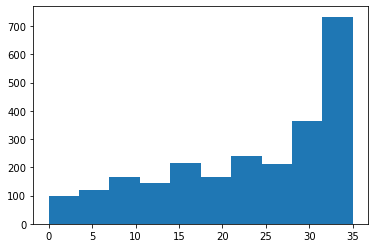


test_2017_04_5k


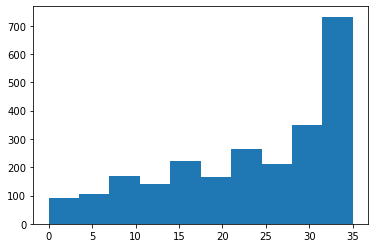


test_2017_05_5k


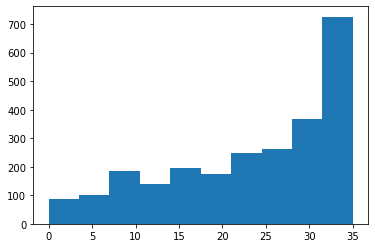


test_2017_06_5k


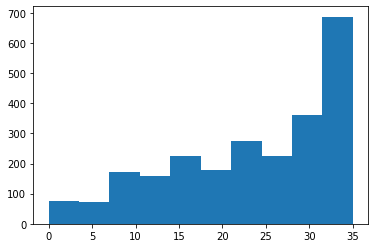


test_2017_07_5k


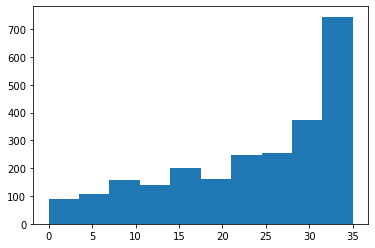


test_2017_08_5k


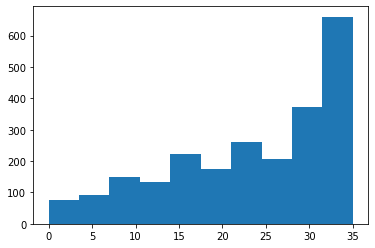


test_2017_09_5k


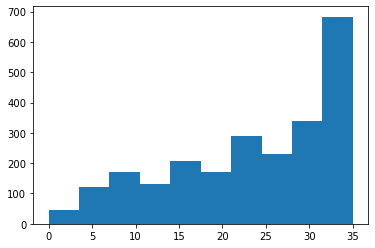


test_2017_10_5k


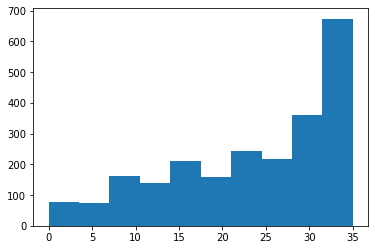


test_2017_11_5k


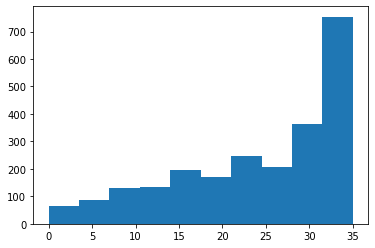


test_2017_12_5k


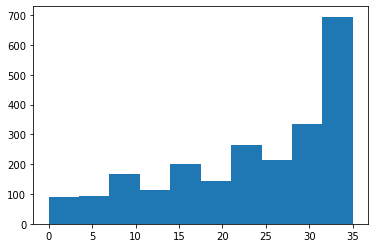


test_2018_01_5k


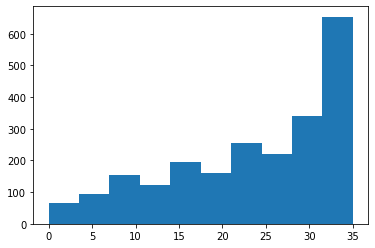


test_2018_02_5k


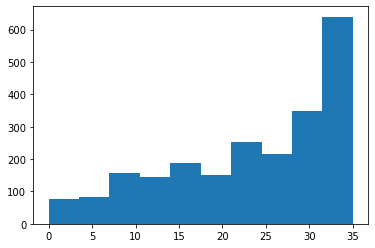


test_2018_03_5k


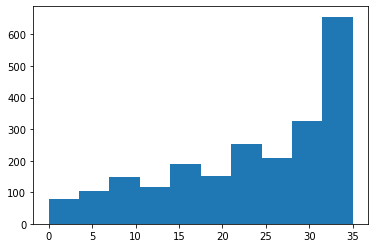


test_2018_04_5k


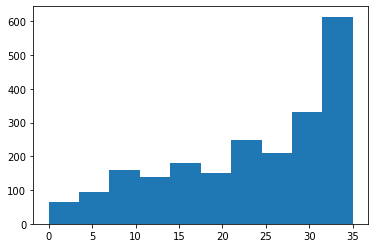


test_2018_05_5k


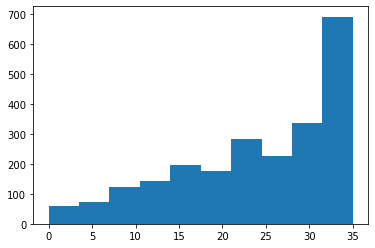


test_2018_06_5k


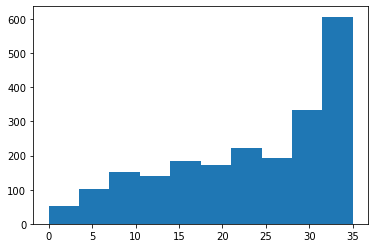


test_2018_07_5k


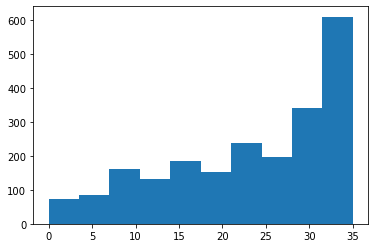


test_2018_08_5k


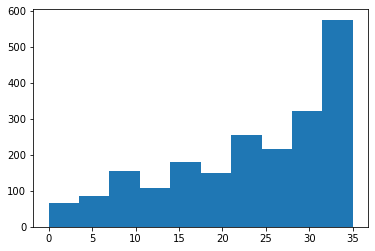


test_2018_09_5k


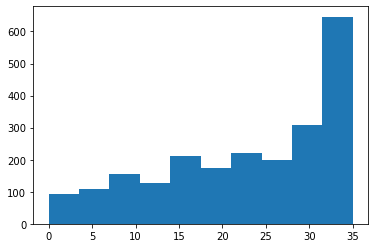


test_2018_10_5k


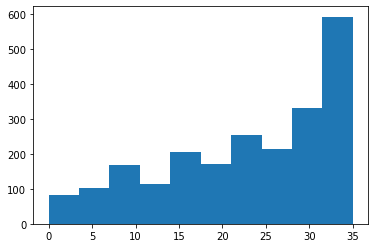


test_2018_11_5k


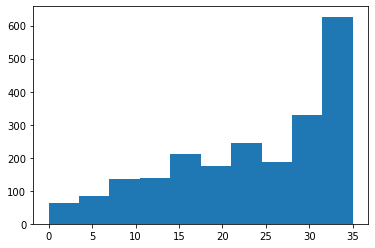


test_2018_12_5k


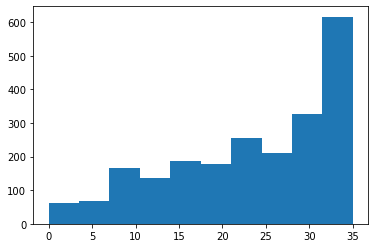


test_2019_01_5k


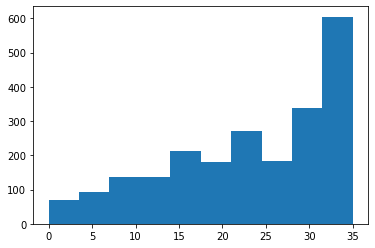


test_2019_02_5k


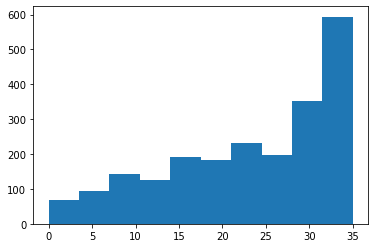


test_2019_03_5k


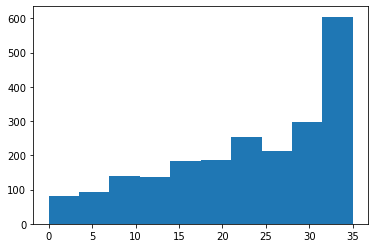


test_2019_04_5k


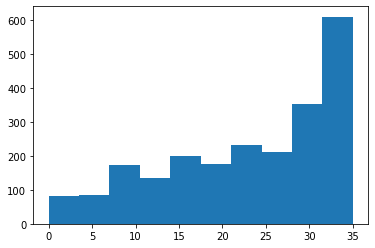


test_2019_05_5k


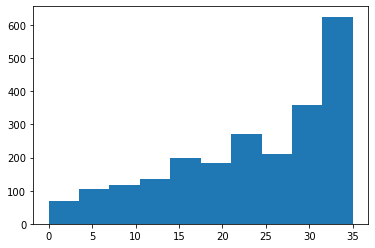


test_2019_06_5k


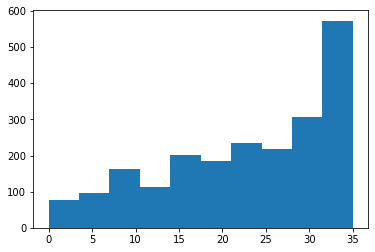


test_2019_07_5k


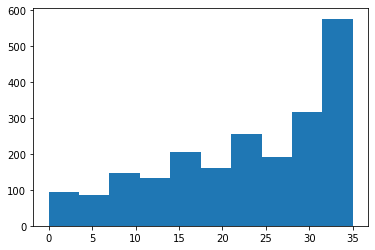


test_2019_08_5k


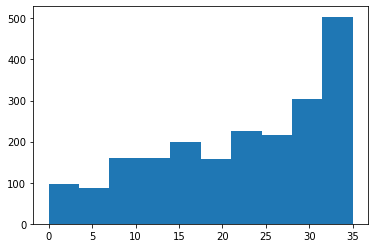


test_2019_09_5k


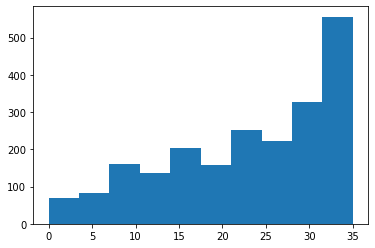


test_2019_10_5k


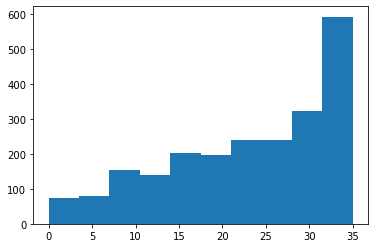


test_2019_11_5k


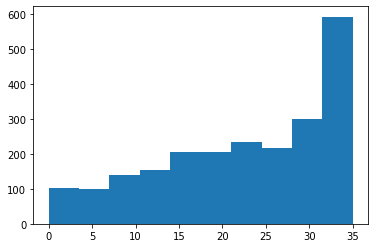


test_2019_12_5k


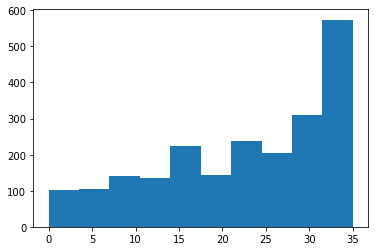


test_2020_01_5k


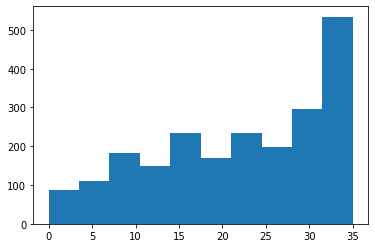


test_2020_02_5k


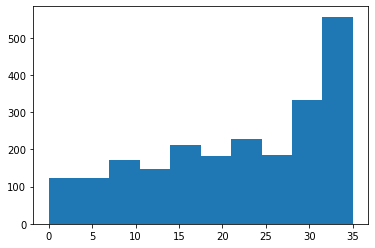

In [111]:
for test_month in sorted(analysis_dict):
    print(test_month)
    plt.hist(analysis_dict[test_month].n_correct)
    plt.show()
    print()